In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import torch
import torch.nn as nn
import numpy as np
import random
from tqdm import tqdm
import scanpy as sc
import torch.nn.functional as F
from collections import defaultdict
from torch.distributions import Normal, kl_divergence
from torch.optim import lr_scheduler
import scanpy as sc
import numpy as np
import pandas as pd
# from umap.umap_ import UMAP
# from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import cudf
from cuml import PCA, UMAP
import cupy as cp

from model_VAE import VAE
from dataloader_VAE import get_h5ad_data, get_dataloader, normalize, inverse_normalize
from train_VAE import train_vae

# 模型训练

In [3]:
# 准备数据

data_list = get_h5ad_data()
norm_data_list, scalers = normalize(data_list)
dataloader = get_dataloader(norm_data_list, batch_size=64)

In [4]:
device = torch.device("cuda:0")
net = VAE().to(device)

num_epoch = 20
epoch_loss = train_vae(net, dataloader, num_epoch, device=device)

100%|█████████| 20/20 [01:56<00:00,  5.84s/it, recon_loss=249.648,kl_loss=5.669]


# 模型生成

In [5]:
latent_list_mix=[]
latent_dict = [[], [], [], [], [], [], [], [], [], [], [], []]  # 12个数组
recon_dict = [[], [], [], [], [], [], [], [], [], [], [], []]  # 12个数组

for i, (x, y) in enumerate(dataloader):
    x = x.float().to(device)
    z, mu, var = net.encoder(x)
    recon = net.decoder(z)
    
    z_np = z.detach().cpu().numpy()
    y_np = y.detach().cpu().numpy()
    recon_np = recon.detach().cpu().numpy()
        
    for (z_i,y_i) in zip(z_np,y_np):
        latent_dict[y_i].append(z_i)        
    for (recon_i,y_i) in zip(recon_np,y_np):
        recon_dict[y_i].append(recon_i)
       

In [6]:
 
latent_list = []
recon_list = []
label_list = []
for index, arr in enumerate(latent_dict):
    latent_list.append(np.asarray(arr))
    for _ in arr:
        label_list.append(index)
    
for arr in recon_dict:
    recon_list.append(np.asarray(arr))

    

In [7]:
for i,j in zip(data_list,latent_list):
    print(f'{i.shape}---{j.shape}')
    

(311, 2000)---(311, 50)
(200, 2000)---(200, 50)
(1158, 2000)---(1158, 50)
(1467, 2000)---(1467, 50)
(5716, 2000)---(5716, 50)
(1026, 2000)---(1026, 50)
(4101, 2000)---(4101, 50)
(6178, 2000)---(6178, 50)
(5442, 2000)---(5442, 50)
(7114, 2000)---(7114, 50)
(1614, 2000)---(1614, 50)
(4404, 2000)---(4404, 50)


In [35]:
true_array = np.concatenate(data_list, axis=0)
latent_array = np.concatenate(latent_list, axis=0)
recon_array = np.concatenate(recon_list, axis=0)
labels_array = np.asarray(label_list)




print(true_array.shape)
print(latent_array.shape)
print(recon_array.shape)
print(labels_array.shape)

(38731, 2000)
(38731, 50)
(38731, 2000)
(38731,)


# 可视化

In [36]:
device = cp.cuda.Device(0)
device.use()

def linearSegmentCMap(num_colors, cmap_name="plasma"):
    '''Construct colormap for linearly segmented colors.'''
    cm = plt.get_cmap(cmap_name)
    color_list = [cm(i//3*3.0/num_colors) for i in range(num_colors)]
    return color_list

In [39]:
pca_pcs = 15
n_neighbors = 200
min_dist = 0.8


# 构建UMAP模型
umap_model = UMAP(n_components=2, n_neighbors=n_neighbors, min_dist=min_dist)
umap_latent_data = umap_model.fit_transform(latent_array)


# 构建PCA和UMAP模型
pca_model_2 = PCA(n_components=pca_pcs, svd_solver="auto")
umap_model_2 = UMAP(n_components=2, n_neighbors=n_neighbors, min_dist=min_dist)
umap_recon_data = umap_model_2.fit_transform(pca_model_2.fit_transform(recon_array))
# umap_recon_data = umap_model_2.fit_transform(pca_model_2.fit_transform(true_array))



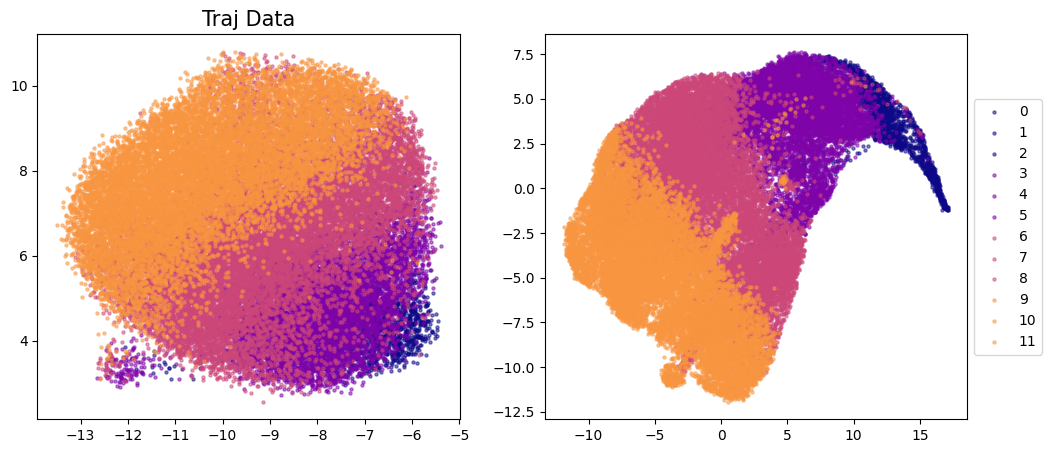

In [41]:
# 画图
'''Plot predictions at all timepoints.'''
unique_tps = np.unique(labels_array).astype(int).tolist()
n_tps = len(unique_tps)
color_list = linearSegmentCMap(n_tps, cmap_name="plasma")
fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(12, 5))
ax1.set_title("Traj Data", fontsize=15)
for i, t in enumerate(unique_tps):
    true_t_idx = np.where(labels_array == t)
    ax1.scatter(
        umap_latent_data[true_t_idx, 0],
        umap_latent_data[true_t_idx, 1],
        label=t,
        color=color_list[i],
        s=5,
        alpha=0.5,
    )
    ax2.scatter(
        umap_recon_data[true_t_idx, 0],
        umap_recon_data[true_t_idx, 1],
        label=t,
        color=color_list[i],
        s=5,
        alpha=0.5,
    )
ax2.legend(loc="center left", bbox_to_anchor=(1.0, 0.5))
plt.show()